In [1]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from numpy import asarray
from numpy import zeros

In [2]:
data = pd.read_csv('./preprocessed_dataset_with_regex.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10168 entries, 0 to 10167
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code                 10168 non-null  object 
 1   comment              10168 non-null  object 
 2   tokens               10168 non-null  object 
 3   code_embedding       10168 non-null  object 
 4   function_calls       10168 non-null  object 
 5   is_constructor       10168 non-null  bool   
 6   parameter_count      10168 non-null  int64  
 7   method_name          10168 non-null  object 
 8   return_type          4615 non-null   object 
 9   method_name_length   10168 non-null  int64  
 10  return_type_numeric  4615 non-null   float64
 11  method_name_string   10168 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 883.9+ KB


In [4]:
max_word_count = data['method_name_string'].str.split().apply(len).max()

In [5]:
max_word_count

13

In [6]:
BATCH_SIZE = 64
EPOCHS = 5
LSTM_NODES =64
NUM_SENTENCES = 10168
MAX_SENTENCE_LENGTH = 70
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [7]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

In [8]:
for line in data.comment:
    input_sentences.append(line)

In [9]:
for line in data.method_name_string:
    output_sentence = line + ' <eos>'
    output_sentence_input = '<sos> ' + line

    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

In [10]:
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 10168
num samples output: 10168
num samples output input: 10168


In [11]:
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172])

Actually proces the parsed message.
process Message <eos>
<sos> process Message


In [12]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(data["code"])
input_integer_seq = input_tokenizer.texts_to_sequences(data["code"])

In [13]:
word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

Total unique words in the input: 37498


In [14]:
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Length of longest sentence in input: 2667


In [15]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

In [16]:
word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

Total unique words in the output: 3548


In [17]:
num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Length of longest sentence in the output: 14


In [18]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (10168, 2667)
encoder_input_sequences[172]: [   0    0    0 ... 1412    7 4533]


In [19]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (10168, 14)
decoder_input_sequences[172]: [ 2 17 96  0  0  0  0  0  0  0  0  0  0  0]


In [20]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["iterator"])
print(word2idx_outputs["has"])
print(word2idx_outputs["compute"])

2
169
37
440


# WORD EMBEDDING

In [21]:
embeddings_dictionary = dict()
glove_file = open(r'./glove/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [22]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))

for word, index in word2idx_inputs.items():
    if index >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
print(embeddings_dictionary["create"])

[-2.6383e-01  2.6373e-01 -3.4955e-01  8.3314e-02  9.0819e-01 -4.8935e-02
 -4.5747e-01 -2.2535e-01  3.0465e-01  3.3276e-01 -4.6850e-01 -2.1108e-01
 -1.8969e-01 -6.1031e-01 -4.8294e-02 -1.1973e-01  4.2292e-01  5.0670e-01
 -3.2303e-01  1.6610e-01 -1.5954e-02 -4.8184e-01  4.6411e-01 -5.6109e-01
 -2.7748e-01 -6.5359e-01 -1.7535e-01 -2.8018e-01 -1.5452e-01 -4.3765e-01
 -1.8374e-01  7.6467e-01 -5.2114e-01 -5.8212e-01  2.4330e-01 -2.9428e-01
  4.9694e-01 -3.4083e-01 -2.6909e-01 -9.0634e-02 -1.0362e-01 -1.6322e-02
 -7.9197e-01 -6.8050e-01 -2.5711e-01  2.2994e-01  7.4819e-02  1.8185e-01
 -3.9566e-01 -6.4057e-01 -5.5135e-01 -1.0861e-01 -2.5924e-01  7.7428e-01
  4.0590e-01 -2.8124e+00  5.4481e-01 -1.1613e-01  1.5227e+00  1.9011e-01
  3.1080e-02  8.9708e-01 -2.2949e-01 -7.3137e-02  9.6343e-01  4.2938e-04
  3.3437e-01  2.0522e-01  3.5985e-01 -9.3257e-01  7.3966e-01 -1.7801e-01
 -3.8467e-01 -4.3444e-01  4.3006e-01  4.8868e-02 -7.8963e-02 -7.3633e-02
 -6.5398e-01  4.0146e-01  6.2592e-01 -2.9576e-02 -3

In [24]:
print(embedding_matrix[540])

[-0.33151999  0.058314    0.15604    -0.41563001 -0.98655999  1.34399998
  0.42739999  0.087866   -0.069399   -0.42807001  0.22164001  0.028742
 -0.75870001  0.29437    -0.0038715  -0.46090001  0.98430997  0.17511
  0.12587     0.76077002 -1.12220001  0.40351999 -0.25479999  0.32334
  0.085255   -0.63966    -0.42072999  0.27932999  0.47734001  0.79558003
  0.08907    -0.24346     0.24969     0.51015002 -0.31711     0.58497
  0.71963     0.59267998  0.25725999 -0.85312003  0.89481997 -0.20599
  0.84898001 -0.13798    -0.51517999  0.33928999 -0.40002    -0.28176999
  0.24051     0.23650999 -0.073356    0.33745    -0.84473002  0.0035665
 -0.24608    -0.39043    -0.48958001  0.85439998 -0.40590999 -0.31503999
 -0.074068   -0.017707   -0.3461     -0.11669     0.24702001 -0.73080999
  0.24682    -0.57183999  0.57960999  0.51990002  0.42667001 -0.51950997
 -0.01364    -0.51003999 -0.4269     -0.061019   -0.48543999  0.43711001
  0.12175     0.50954002  0.48659    -0.96977001 -0.47679999  0.31

In [25]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [26]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [27]:
decoder_targets_one_hot.shape

(10168, 14, 3549)

In [28]:
for i, d in enumerate(decoder_input_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [29]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [30]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [31]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [33]:
import keras_metrics

In [38]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [39]:
from keras.utils import plot_model

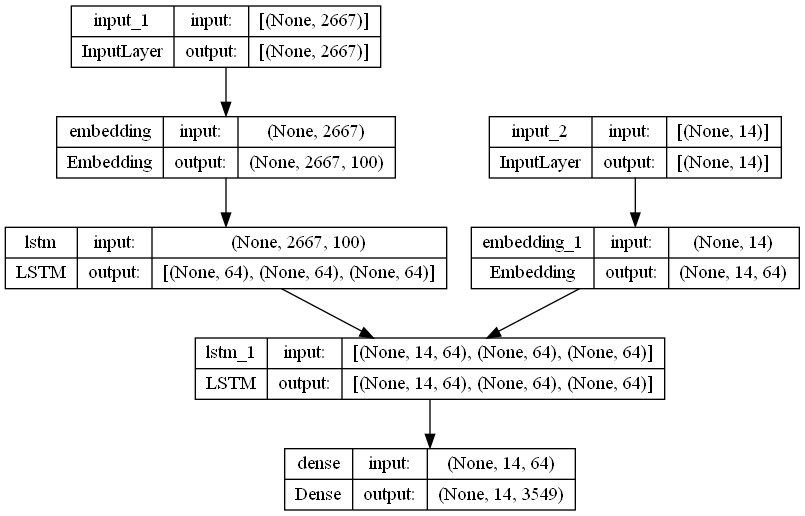

In [40]:
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [41]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/5
143/143 [==============================] - 305s 2s/step - loss: 2.5894 - accuracy: 0.7635 - val_loss: 1.3961 - val_accuracy: 0.8172
Epoch 2/5
143/143 [==============================] - 285s 2s/step - loss: 1.2162 - accuracy: 0.8231 - val_loss: 1.1873 - val_accuracy: 0.8176
Epoch 3/5
143/143 [==============================] - 299s 2s/step - loss: 1.0779 - accuracy: 0.8305 - val_loss: 1.0950 - val_accuracy: 0.8300
Epoch 4/5
143/143 [==============================] - 294s 2s/step - loss: 1.0026 - accuracy: 0.8383 - val_loss: 1.0394 - val_accuracy: 0.8356
Epoch 5/5
143/143 [==============================] - 280s 2s/step - loss: 0.9472 - accuracy: 0.8450 - val_loss: 0.9987 - val_accuracy: 0.8437


In [42]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [43]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [44]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [45]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [46]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [47]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

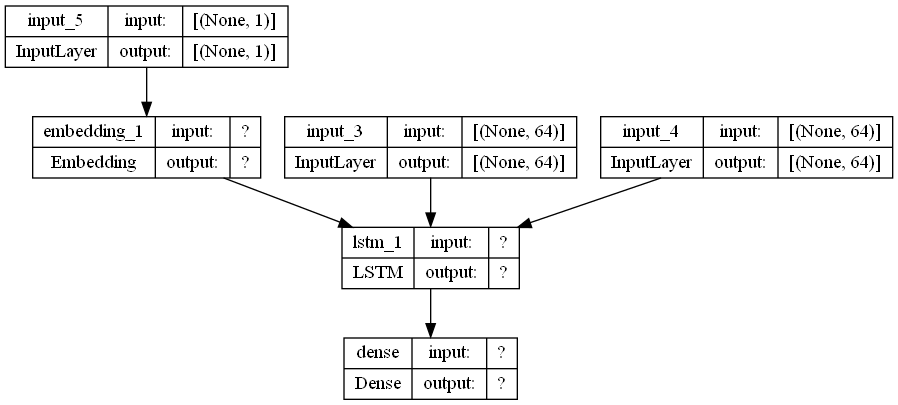

In [48]:
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

# Prediction

In [49]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [50]:
def return_method_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

# Testing Model

In [54]:
i = np.random.choice(len(data.code))
input_seq = encoder_input_sequences[i:i+1]
translation = return_method_sentence(input_seq)

1/1 [==============================] - 0s 25ms/step


In [72]:
kelimeler = translation.split()

In [73]:
for i in range(len(kelimeler)):
    if kelimeler[i] == "<sos>":
        kelimeler.pop(i)
        kelimeler.insert(i, "")
        break

In [74]:
kelimeler

['', 'is', 'to', 'string', 'string']

In [75]:
benzersiz_kelimeler = list(set(kelimeler))

In [83]:
benzersiz_kelimeler

['', 'to', 'is', 'string']

In [76]:
yeni_string = "_".join(benzersiz_kelimeler)

In [82]:
print('-')
print('Input:', data.code[985])
print("Response:" + yeni_string[1:])

-
Input: public class Main
{
public final String toString(){
  if (this.initialized == false) {
    return null;
  }
  return paramSpi.engineToString();
}
}
Response:to_is_string
